# CORA (Basic Model)

1. First, create a new ```python venv```.
2. Install ```dgl```, ```dglgo```, ```torch_geometric```, and ```matplotlib```

In [1]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from dgl.data import CoraGraphDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The following is implemented using Danish's GCN model which he sent us earlier in the quarter.

In [2]:
# Define the GCN model
class GCN(nn.Module):
    def __init__(self, g, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dgl.nn.GraphConv(in_feats, h_feats)
        self.conv2 = dgl.nn.GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

# Load the datasets
cora_dataset = CoraGraphDataset()

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [3]:
g = cora_dataset[0]
features = g.ndata['feat']
labels = g.ndata['label']
train_mask = g.ndata['train_mask']

in_feats = features.shape[1]
h_feats = 64
num_classes = cora_dataset.num_classes
model = GCN(g, in_feats, h_feats, num_classes)

def train():
    # Train the model
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    # for _ in range(200):
    model.train()
    logits = model(g, features)
    loss = F.cross_entropy(logits[train_mask], labels[train_mask])
        # print(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
    return loss.item()

In [4]:
def save_embeddings_and_edges(dataset, dataset_name):
    model.eval()
    with torch.no_grad():
        embeddings = model(g, features)
    print(embeddings.shape)
    np.save(f'{dataset_name}_embeddings.npy', embeddings.detach().numpy())


    edge_index = g.edges()
    np.save(f'{dataset_name}_edge_index.npy', np.vstack((edge_index[0].numpy(), edge_index[1].numpy())))

In [5]:
train()
save_embeddings_and_edges(cora_dataset, 'cora')

torch.Size([2708, 7])


In [6]:
def test():
    data = cora_dataset[0].to(device)
    model.eval()
    out = model(data, features)
    pred = out.argmax(dim=1)

    incorrect_indices = (pred[data.ndata["test_mask"]] != data.ndata["label"][data.ndata["test_mask"]]).nonzero()

    print("Incorrect Predictions Indices:", incorrect_indices.flatten().tolist())

    acc = (pred[data.ndata["test_mask"]] == data.ndata["label"][data.ndata["test_mask"]]).sum().item() / data.ndata["test_mask"].sum().item()
    return acc

for epoch in range(1, 1001):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

Incorrect Predictions Indices: [0, 2, 3, 7, 9, 14, 16, 17, 19, 20, 21, 24, 27, 31, 32, 33, 34, 35, 38, 42, 50, 51, 53, 56, 57, 59, 60, 61, 62, 64, 65, 66, 67, 68, 70, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84, 87, 89, 90, 91, 92, 94, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 108, 109, 110, 111, 113, 114, 115, 116, 118, 120, 121, 126, 129, 132, 134, 136, 137, 138, 141, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 159, 160, 161, 163, 164, 165, 166, 167, 168, 169, 170, 171, 174, 175, 185, 186, 187, 190, 191, 192, 194, 198, 199, 200, 203, 206, 207, 208, 209, 210, 211, 216, 220, 221, 223, 224, 225, 226, 227, 228, 229, 230, 232, 233, 234, 235, 236, 237, 238, 239, 242, 246, 249, 253, 264, 265, 266, 267, 268, 269, 270, 271, 272, 274, 276, 277, 278, 279, 280, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 295, 297, 298, 299, 300, 301, 303, 304, 305, 306, 307, 309, 312, 314, 315, 316, 318, 319, 320, 322, 323, 324, 325, 327, 328, 329, 330, 331, 333, 334, 335, 336, 337, 338

The following shows the 10 nodes with the highest degree.

threshold 0.011082379017362394


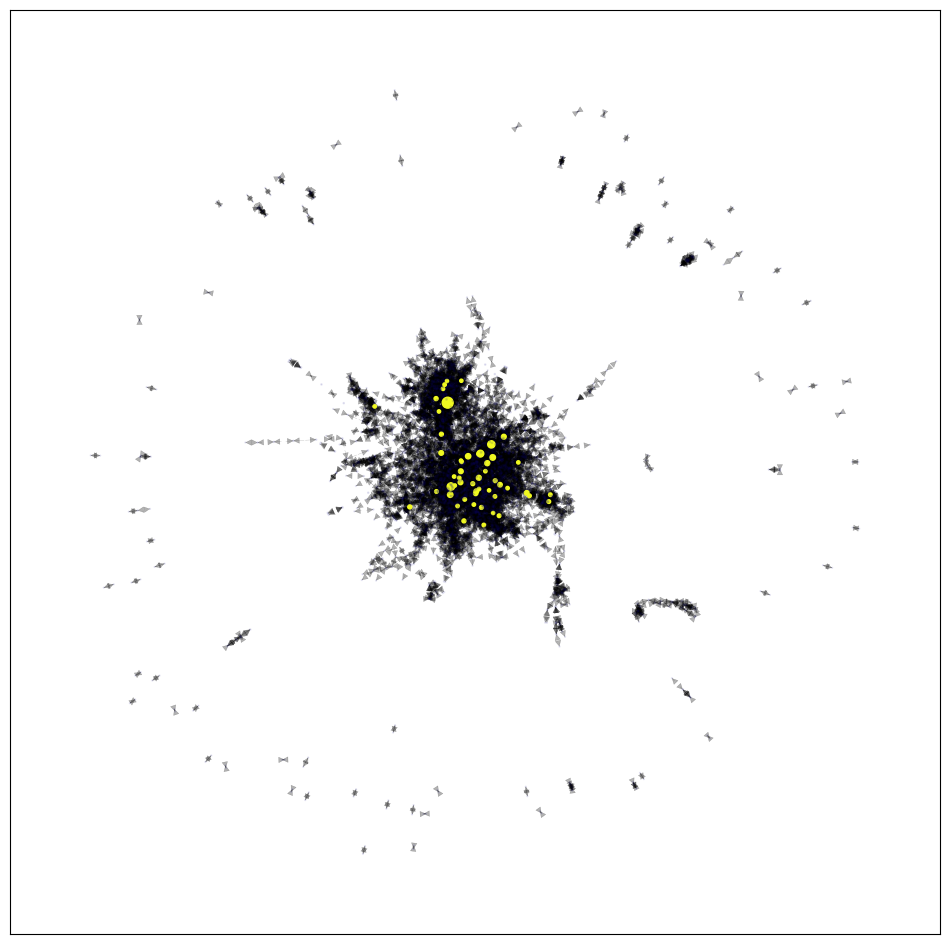

In [16]:
import networkx as nx
from dgl import to_networkx
import matplotlib.pyplot as plt

G = to_networkx(g)
pos = nx.spring_layout(G, seed=42)
cent = nx.degree_centrality(G)
node_size = list(map(lambda x: x * 500, cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[50]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.show()

threshold 0.05762837089028445


/Users/willcorcoran__/Classes/2023.2024/SINGH-RESEARCH/.venv/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


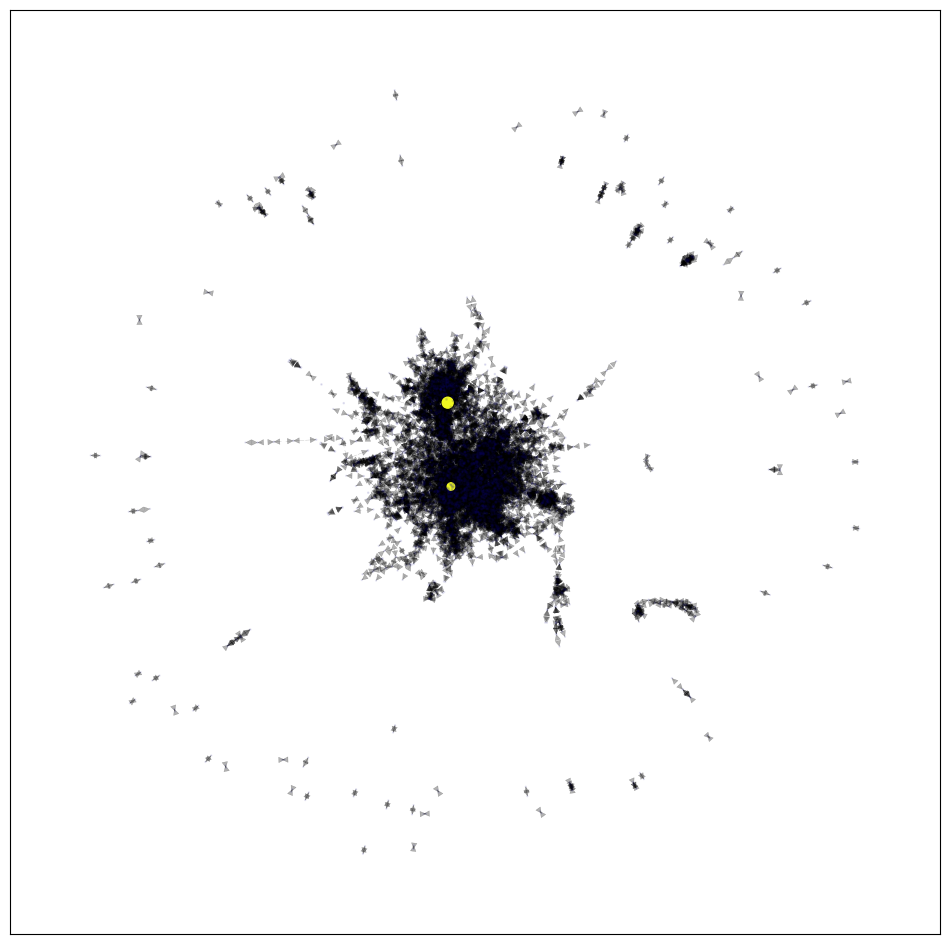

In [29]:
threshold = sorted(cent_array, reverse=True)[0]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.show()